In [1]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.10.1
TF-Hub version:  0.12.0
Eager mode enabled:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

def resize_image_to_square(image_np, image_size=(256,256), preserve_aspect_ratio=True):
    image_np_extra = image_np.astype(np.float32)[np.newaxis, ...]
    if image_np_extra.max() > 1.0:
        image_np_extra = image_np_extra / 255.
    if len(image_np_extra.shape) == 3:
      image_np_extra = tf.stack([image_np_extra, image_np_extra, image_np_extra], axis=-1)
    image_np_extra = crop_center(image_np_extra)
    image_np_extra = tf.image.resize(image_np_extra, image_size, preserve_aspect_ratio=True)
    return image_np_extra

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

430903/430903 [==============================] - 1s 2us/step


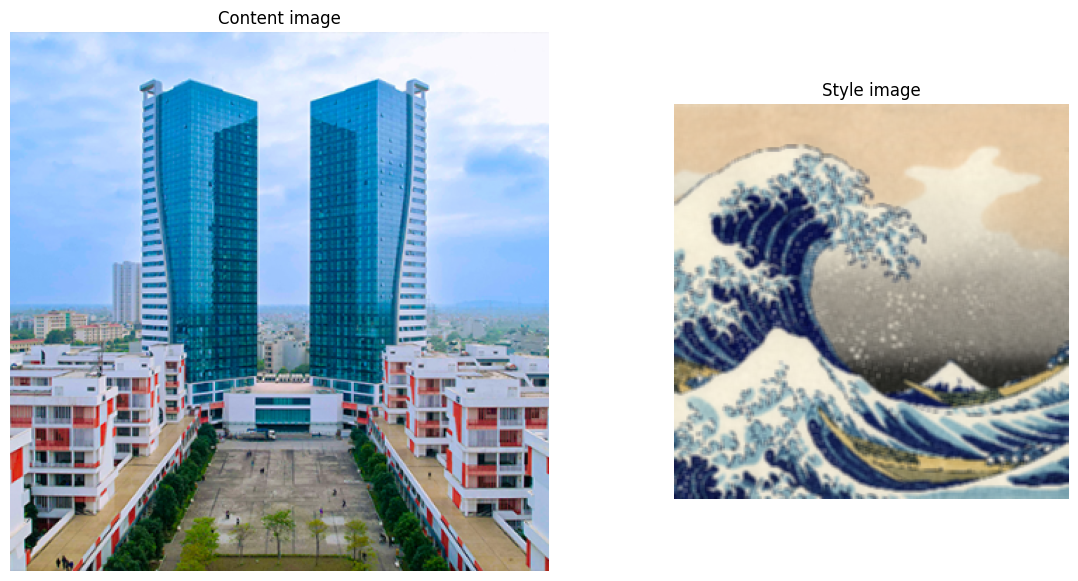

In [19]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/2/2f/PHENNIKA-thumnail-1.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the
# recommended image size for the style image (though, other sizes work as
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [4]:
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [20]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

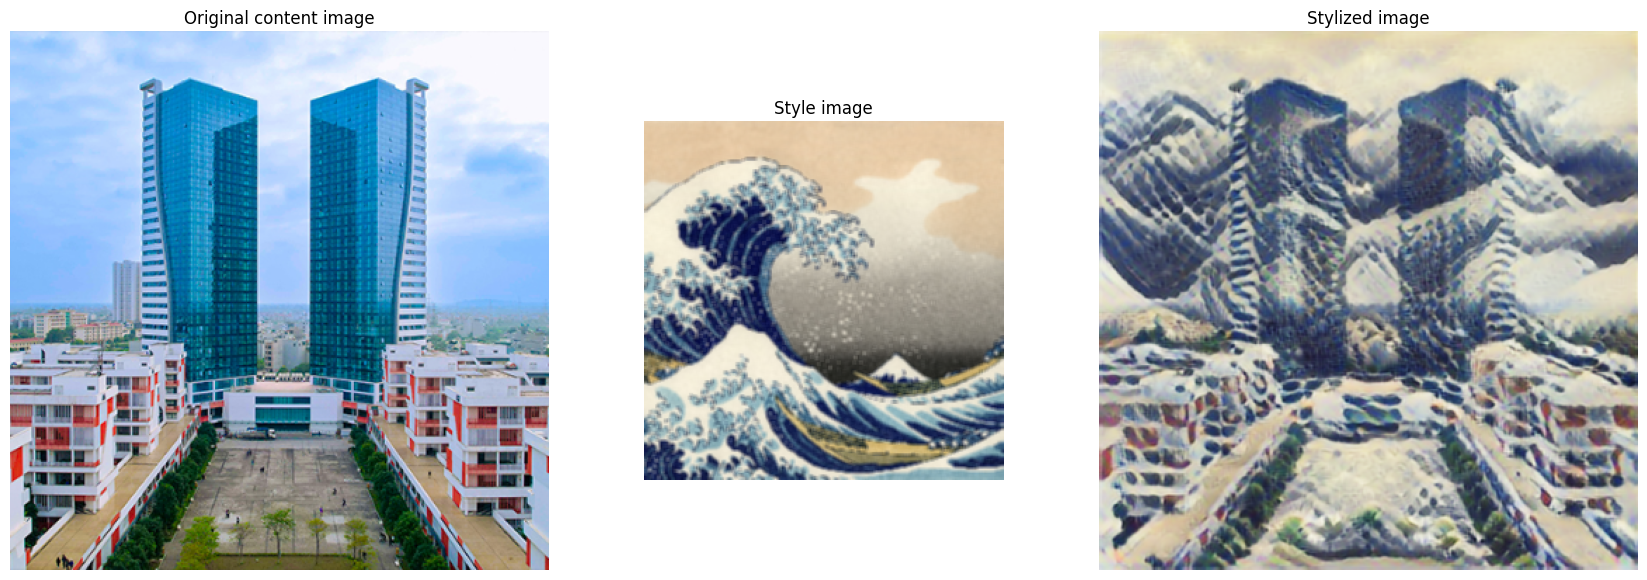

In [21]:
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

In [23]:
# URLs ảnh nội dung
content_urls = dict(
  phenikaa='https://upload.wikimedia.org/wikipedia/commons/2/2f/PHENNIKA-thumnail-1.jpg',
  tuebingen='https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg',
  grace_hopper='https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg',
)

# URLs ảnh phong cách
style_urls = dict(
  kandinsky_composition_7='https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
  cartoon_like='https://github.com/lengstrom/fast-style-transfer/raw/master/examples/style/rain_princess.jpg',
    starry_night='https://upload.wikimedia.org/wikipedia/commons/2/29/Demdaysao.jpg'
)

# Kích thước ảnh
content_image_size = 384
style_image_size = 256

# Tải ảnh nội dung
content_images = {
    k: load_image(v, (content_image_size, content_image_size))
    for k, v in content_urls.items()
}

# Tải ảnh phong cách (sau khi đã loại bỏ các URL bị lỗi)
style_images = {
    k: load_image(v, (style_image_size, style_image_size))
    for k, v in style_urls.items()
}

# Làm mượt ảnh style (trung bình cộng qua pool)
style_images = {
    k: tf.nn.avg_pool(style_image, ksize=[3, 3], strides=[1, 1], padding='SAME')
    for k, style_image in style_images.items()
}


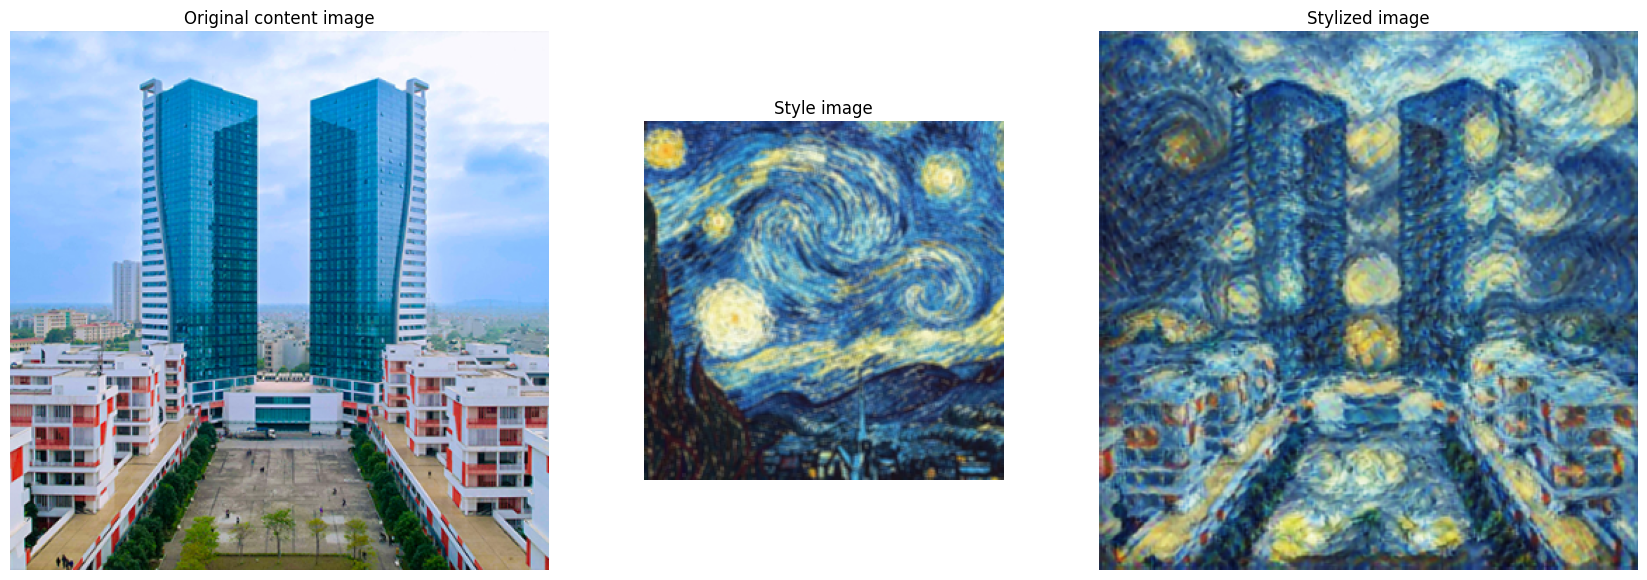

In [25]:
content_name = 'phenikaa'  # @param ['sea_turtle', 'tuebingen', 'grace_hopper']
style_name = 'starry_night'  # @param ['kanagawa_great_wave', 'kandinsky_composition_7', 'hubble_pillars_of_creation', 'van_gogh_starry_night', 'turner_nantes', 'munch_scream', 'picasso_demoiselles_avignon', 'picasso_violin', 'picasso_bottle_of_rum', 'fire', 'derkovits_woman_head', 'amadeo_style_life', 'derkovtis_talig', 'amadeo_cardoso']

stylized_image = hub_module(tf.constant(content_images[content_name]),
                            tf.constant(style_images[style_name]))[0]

show_n([content_images[content_name], style_images[style_name], stylized_image],
       titles=['Original content image', 'Style image', 'Stylized image'])

In [18]:
import cv2
import numpy as np
import tensorflow as tf
import time

# Danh sách style (tên phải tồn tại trong style_images)
style_names = ["cartoon_like", "kandinsky_composition_7", "starry_night" ]
style_index = 0  # bắt đầu từ style đầu tiên

frame_size = 256

# Kiểm tra style có tồn tại
for name in style_names:
    if name not in style_images:
        raise KeyError(f"Style '{name}' không có trong style_images.")

cap = cv2.VideoCapture(0)

def resize_image_to_square(img_np, image_size=(256, 256)):
    img = tf.convert_to_tensor(img_np, dtype=tf.float32)
    img = tf.image.resize(img, image_size)
    img = img[tf.newaxis, ...] / 255.0  # Normalize
    return img

prev_time = time.time()

while True:
    flag, frame = cap.read()
    if not flag:
        print("Lỗi khi đọc khung hình từ camera.")
        break

    # Tính FPS
    curr_time = time.time()
    fps = 1.0 / (curr_time - prev_time)
    prev_time = curr_time

    # Chuẩn hóa ảnh content
    frame_resized = cv2.resize(frame, (frame_size, frame_size))
    image_rgb_np = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
    content_tensor = resize_image_to_square(image_rgb_np, image_size=(frame_size, frame_size))

    # Lấy ảnh style hiện tại
    style_tensor = tf.convert_to_tensor(style_images[style_names[style_index]], dtype=tf.float32)

    # Style transfer
    outputs = hub_module(content_tensor, style_tensor)
    stylized_image = outputs[0]

    # Convert sang ảnh OpenCV
    image_pil = tf.keras.preprocessing.image.array_to_img(stylized_image[0])
    image_bgr_np = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)

    # Ghép ảnh
    combined = np.hstack((frame_resized, image_bgr_np))

    #Phóng to màn hình
    display_frame = cv2.resize(combined, (combined.shape[1]*2, combined.shape[0]*2), interpolation=cv2.INTER_LINEAR)

    # Hiển thị FPS + tên style + các phím thay đổi style
    cv2.putText(display_frame, f"FPS: {fps:.2f} | Style: {style_names[style_index]}", (10, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.putText(display_frame, f"[1] {style_names[0]}", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
    cv2.putText(display_frame, f"[2] {style_names[1]}", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
    cv2.putText(display_frame, f"[3] {style_names[2]}", (10, 80),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
    cv2.putText(display_frame, f"[q] Quit", (10, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    cv2.imshow("Original | Stylized", display_frame)

    # Phím điều khiển
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('1'):
        style_index = 0
    elif key == ord('2'):
        style_index = 1
    elif key == ord('3'):
        style_index = 2

cap.release()
cv2.destroyAllWindows()